Loading RT Structure file: C:/Users/jhrad/Desktop/Rackaton Data/SAMPLE_001/RS.1.2.246.352.221.46272062591570509005209218152822185346.dcm
Available ROIs: ['zRingPTV_Mid01', 'zRingPTV_Mid00', 'CouchSurface', 'CouchInterior', 'zRingPTV_Low', 'zRingPTV_High', 'zOptPTV_Mid01', 'zOptPTV_Mid00', 'zOptPTV_Low', 'zOptPTV_High', 'z_Planveri', 'z_Avoid', 'z_Artifact', 'Trachea', 'SpinalCord_PRV', 'SpinalCord', 'Retina_R', 'Retina_L', 'PTV_Mid01', 'PTV_Mid00', 'PTV_Low', 'PTV_High', 'PTV_all', 'Pituitary', 'Parotid_R', 'Parotid_L', 'Oral_Cavity-PTV', 'Oral_Cavity', 'OpticNrv_R', 'OpticNrv_L', 'OpticChiasm', 'Musc_Constrict', 'Mandible', 'Lungs', 'Lens_R', 'Lens_L', 'Heart', 'GTV', 'Glottis', 'Glnd_Submand_R', 'Glnd_Submand_L', 'Glnd_Lacrimal_R', 'Glnd_Lacrimal_L', 'Eye_R', 'Eye_L', 'External', 'Esophagus', 'CTV_Mid01', 'CTV_Mid00', 'CTV_Low', 'CTV_High', 'Cochlea_R', 'Cochlea_L', 'Brainstem', 'Brain', 'Bone', 'A_Carotid_R', 'A_Carotid_L', 'Dose 75[%]']
Extracted contours for: ['SpinalCord_PRV', 'S

C:\Users\jhrad\AppData\Local\Temp\ipykernel_1340\490139892.py:108: UserWarning: The following kwargs were not used by contour: 'label'
  axes[1].contour(mask, colors=[colors[i]], linewidths=2, label=roi_name)
C:\Users\jhrad\AppData\Local\Temp\ipykernel_1340\490139892.py:112: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend()


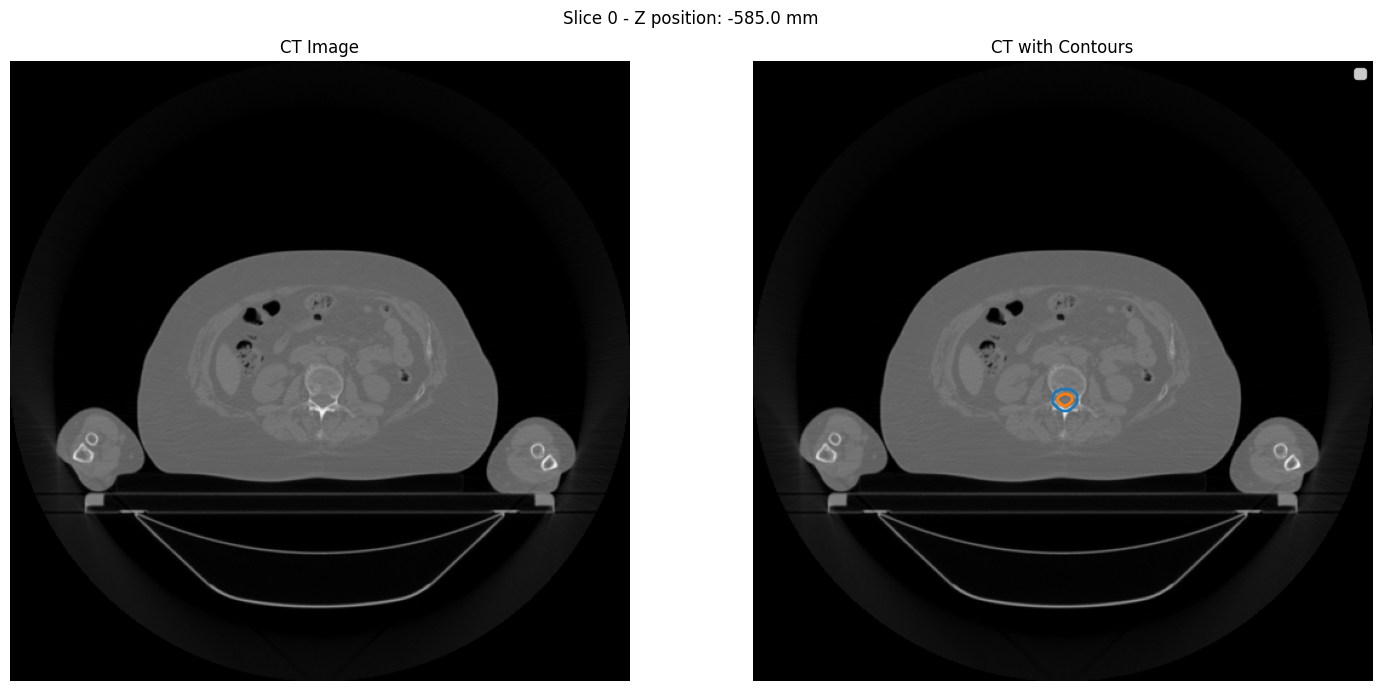

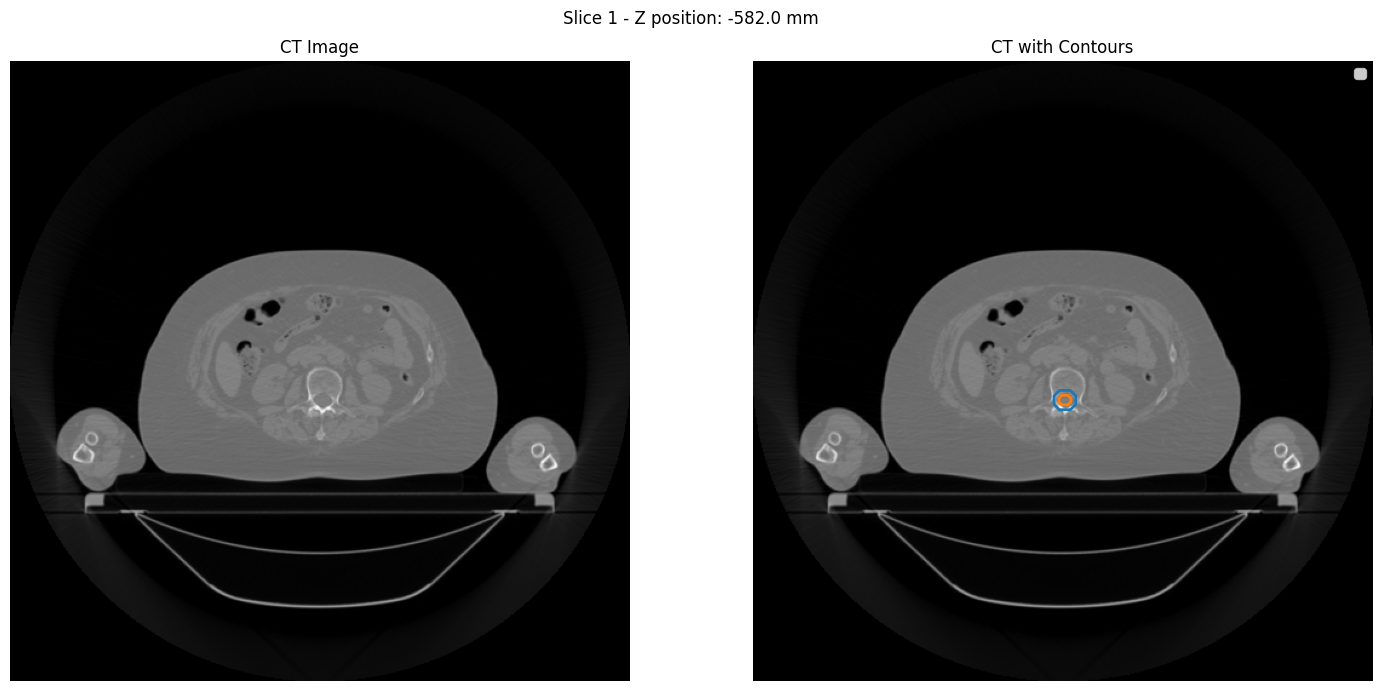

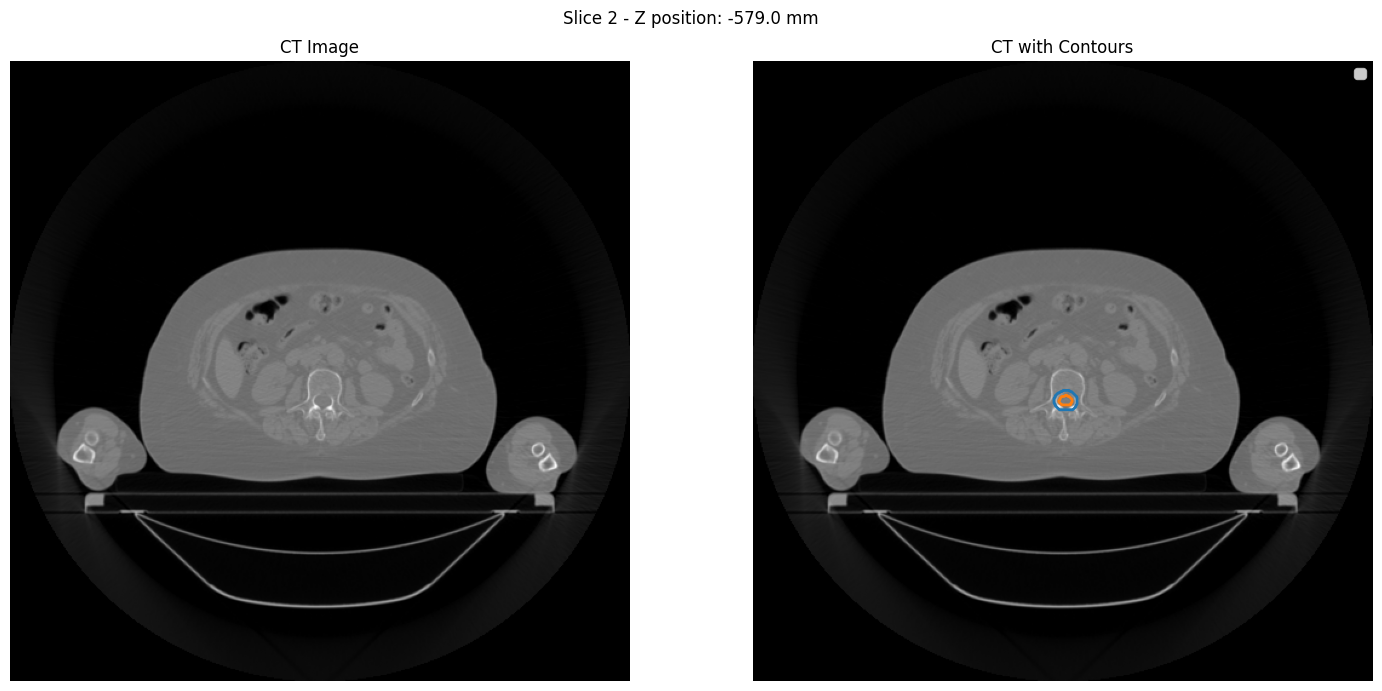

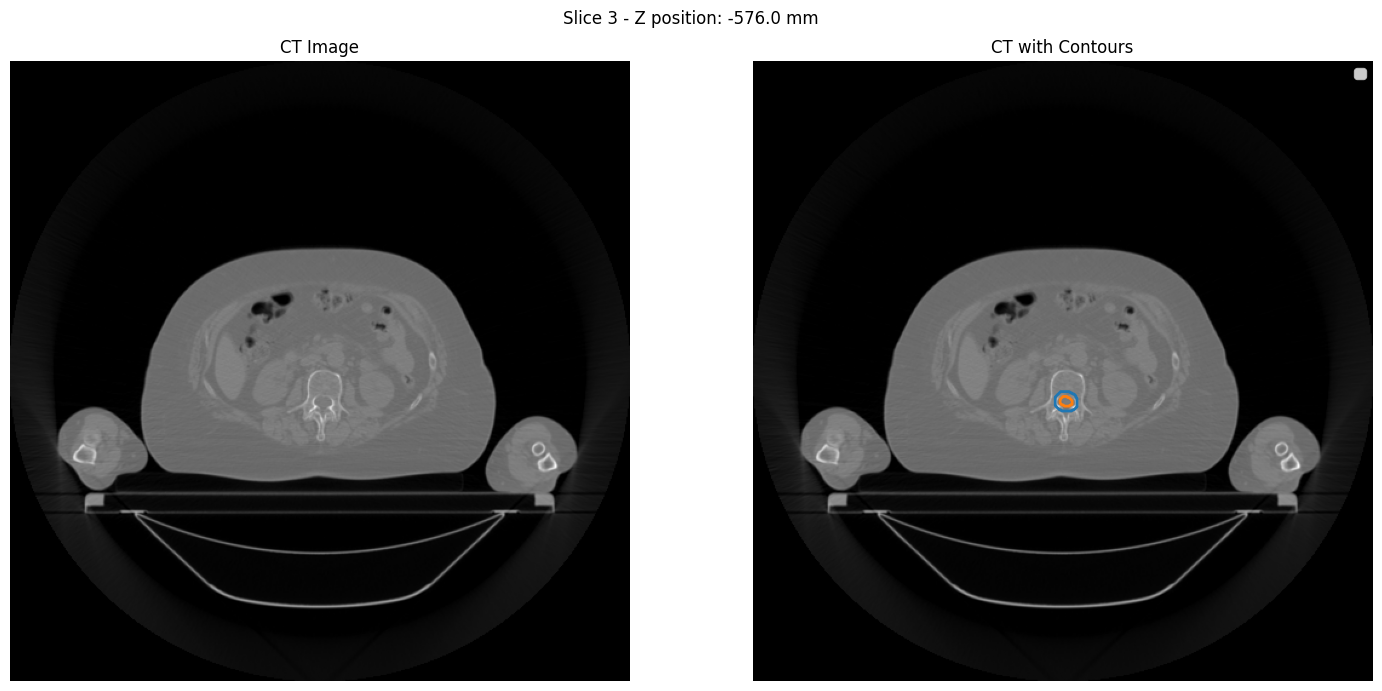

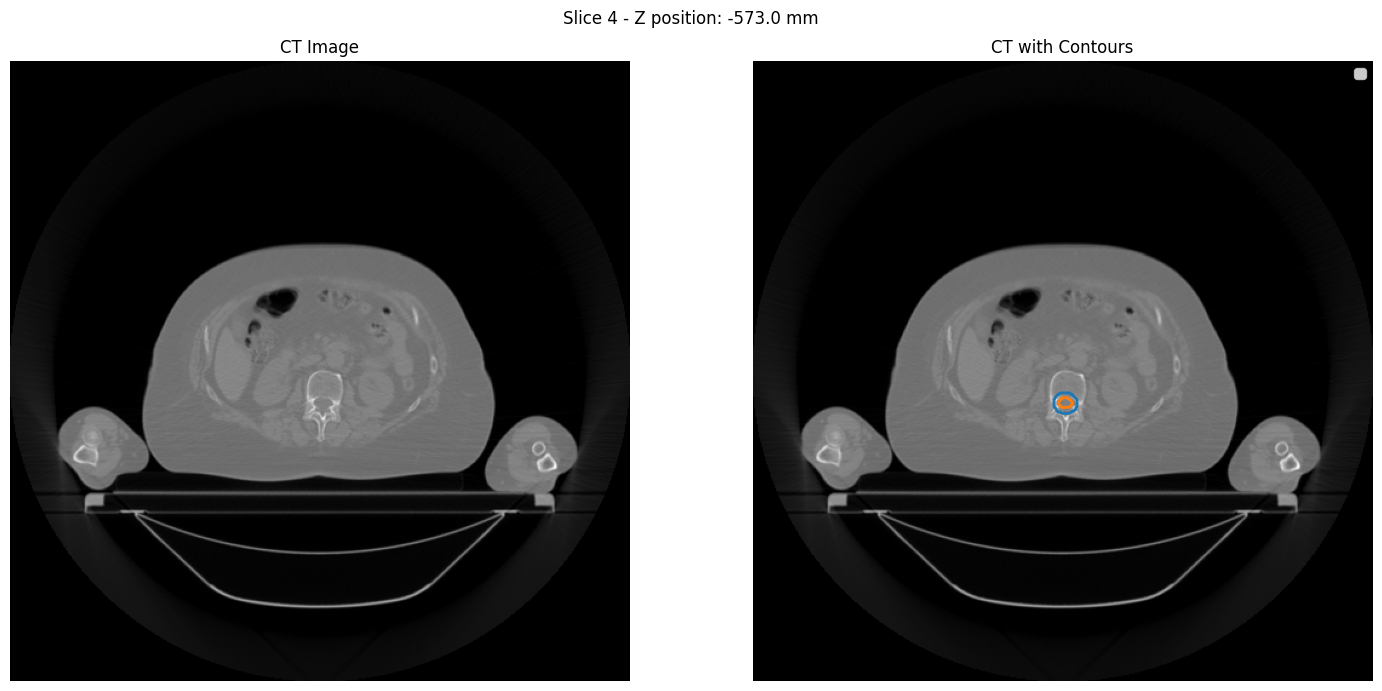

KeyboardInterrupt: 

In [1]:
import os
import numpy as np
import pydicom
import matplotlib.pyplot as plt
from skimage.draw import polygon2mask
from skimage.transform import resize

def load_rtstruct(rtstruct_path, target_contours=None):
    """Load RTSTRUCT file and extract contours
    
    Args:
        rtstruct_path (str): Path to RTSTRUCT file
        target_contours (list): List of contour names to extract (e.g., ['GTV', 'CTV', 'PTV'])
                              If None, extracts all contours
    """
    print(f"Loading RT Structure file: {rtstruct_path}")
    rtstruct = pydicom.dcmread(rtstruct_path)
    
    # Get ROI names and numbers
    roi_names = {roi.ROINumber: roi.ROIName for roi in rtstruct.StructureSetROISequence}
    print(f"Available ROIs: {list(roi_names.values())}")
    
    # Extract contour data
    contours = {}
    instance_uids = {}
    
    for roi in rtstruct.ROIContourSequence:
        roi_number = roi.ReferencedROINumber
        roi_name = roi_names[roi_number]
        
        # Skip if not in target contours
        if target_contours is not None and not any(target in roi_name for target in target_contours):
            continue
            
        contours[roi_name] = []
        instance_uids[roi_name] = []
        
        if hasattr(roi, 'ContourSequence'):
            for contour in roi.ContourSequence:
                instance_uid = contour.ContourImageSequence[0].ReferencedSOPInstanceUID
                instance_uids[roi_name].append(instance_uid)
                contour_data = contour.ContourData
                points = np.array(contour_data).reshape(-1, 3)
                contours[roi_name].append(points)
    
    print(f"Extracted contours for: {list(contours.keys())}")
    return contours, instance_uids, rtstruct

def load_ct_image(ct_path):
    """Load and normalize CT image"""
    ct_dicom = pydicom.dcmread(ct_path)
    ct_array = ct_dicom.pixel_array
    
    # Normalize to 0-1 range
    ct_normalized = (ct_array - ct_array.min()) / (ct_array.max() - ct_array.min())
    return ct_normalized, ct_dicom

def get_ct_z_position(ct_dicom):
    """Get z-position from CT DICOM file"""
    return ct_dicom.ImagePositionPatient[2]

def contour_to_mask(contour, img_size, ct_dicom):
    """Convert contour points to a binary mask"""
    if len(contour) < 3:
        return np.zeros(img_size, dtype=np.bool_)
    
    # Extract x and y coordinates
    x_points = contour[:, 0]
    y_points = contour[:, 1]
    
    # Get image position and orientation from CT
    img_pos = ct_dicom.ImagePositionPatient
    img_ori = ct_dicom.ImageOrientationPatient
    pixel_spacing = ct_dicom.PixelSpacing
    
    # Convert from patient coordinates to pixel coordinates
    x_pixels = (x_points - img_pos[0]) / pixel_spacing[0]
    y_pixels = (y_points - img_pos[1]) / pixel_spacing[1]
    
    # Create polygon vertices
    vertices = np.column_stack((y_pixels, x_pixels))
    
    # Create mask
    try:
        mask = polygon2mask(img_size, vertices)
        return mask
    except:
        print(f"Error creating mask for contour with {len(contour)} points")
        return np.zeros(img_size, dtype=np.bool_)

def visualize_slice(ct_array, masks, roi_names, slice_idx, z_position):
    """Visualize CT slice with overlaid contours"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 7))
    
    # Plot CT image
    axes[0].imshow(ct_array, cmap='gray')
    axes[0].set_title('CT Image')
    axes[0].axis('off')
    
    # Plot CT with contours
    axes[1].imshow(ct_array, cmap='gray')
    
    # Define colors for different ROIs
    colors = plt.cm.tab10(np.linspace(0, 1, len(roi_names)))
    
    for i, (roi_name, mask) in enumerate(masks.items()):
        if mask.any():  # Only plot if mask is not empty
            axes[1].contour(mask, colors=[colors[i]], linewidths=2, label=roi_name)
    
    axes[1].set_title('CT with Contours')
    axes[1].axis('off')
    axes[1].legend()
    
    plt.suptitle(f'Slice {slice_idx} - Z position: {z_position:.1f} mm')
    plt.tight_layout()
    return fig

def visualize_contours(rtstruct_path, ct_dir, target_contours=None):
    """Visualize contours from RTSTRUCT on corresponding CT images
    
    Args:
        rtstruct_path (str): Path to RTSTRUCT file
        ct_dir (str): Directory containing CT files
        target_contours (list): List of contour names to visualize (e.g., ['GTV', 'CTV', 'PTV'])
    """
    # Load RTSTRUCT and extract contours
    contours, instance_uids, rtstruct = load_rtstruct(rtstruct_path, target_contours)
    
    if not contours:
        print("No matching contours found!")
        return
    
    # Get unique CT instance UIDs
    unique_ct_uids = set()
    for uids in instance_uids.values():
        unique_ct_uids.update(uids)
    
    print(f"Found {len(unique_ct_uids)} CT slices with contours")
    
    # Load all CT images and get their z-positions
    ct_slices = []
    for ct_uid in unique_ct_uids:
        ct_path = os.path.join(ct_dir, f"CT.{ct_uid}.dcm")
        if not os.path.exists(ct_path):
            print(f"CT file not found: {ct_path}")
            continue
        
        ct_array, ct_dicom = load_ct_image(ct_path)
        z_position = get_ct_z_position(ct_dicom)
        ct_slices.append((ct_uid, ct_array, ct_dicom, z_position))
    
    # Sort CT slices by z-position
    ct_slices.sort(key=lambda x: x[3])
    
    # Process each CT slice
    for slice_idx, (ct_uid, ct_array, ct_dicom, z_position) in enumerate(ct_slices):
        img_size = ct_array.shape
        
        # Create masks for each ROI
        masks = {}
        for roi_name, roi_contours in contours.items():
            roi_mask = np.zeros(img_size, dtype=np.bool_)
            for contour, uid in zip(roi_contours, instance_uids[roi_name]):
                if uid == ct_uid:
                    mask = contour_to_mask(contour, img_size, ct_dicom)
                    roi_mask |= mask
            masks[roi_name] = roi_mask
        
        # Visualize the slice
        fig = visualize_slice(ct_array, masks, contours.keys(), slice_idx, z_position)
        plt.show()
        plt.close(fig)

if __name__ == "__main__":
    # Example usage
    rtstruct_path = "C:/Users/jhrad/Desktop/Rackaton Data/SAMPLE_001/RS.1.2.246.352.221.46272062591570509005209218152822185346.dcm"
    ct_dir = "C:/Users/jhrad/Desktop/Rackaton Data/SAMPLE_001"
    target_contours = ['SpinalCord', 'Parotid', 'Submand', 'Esophagus']  # Specify which contours to visualize
    
    visualize_contours(rtstruct_path, ct_dir, target_contours)